# Params

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# device = 'cpu'
map_vpc = {'1': 0, '3': 1, '4': 2, '5': 3, '0': 4, '6': 5} # map labels: 1 = benign (0), we don't have 2, i = Gleason i (i-2) for i=[3:5]
num_classes = 6
batch_size = 32
magnifications = [10, 20, 40]
magnification=40
stains = ['HnE']
fold = 'fold1'

if fold == 'fold1':
    train_slides_vpc = [2, 5, 6, 7]
    val_slides_vpc = [3]
    test_slides_vpc = [1]
elif fold == 'fold2':
    train_slides_vpc = [1, 3, 6, 7]
    val_slides_vpc = [2]
    test_slides_vpc = [5]
elif fold == 'fold3':
    train_slides_vpc = [1, 2, 3, 5]
    val_slides_vpc = [7]
    test_slides_vpc = [6]
# else:
#     assert False 'Please choose the correct fold! - {"fold1", "fold2", "fold3"}'

# NEW: path to labels CSV + soft/hard label switch
labels_csv = "../data/VPC/patch_labels_majority.csv"  # <-- set to your CSV path
use_soft_labels = False  # True to use p0..p5; False to use hard_label

# model path unchanged
model_results_path = '../models/model_VPC/' + str(magnification) + '/' + fold + '/256_aug_model'

os.makedirs(os.path.dirname(model_results_path), exist_ok=True)


# Deprecated with CSV (images read via absolute paths in the CSV)
# path_VPC = "/home/user01/MS-RGCN/data/VPC/multiscale_patches_Train/"


# Import

In [4]:
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import roc_auc_score
import numpy as np
import staintools
import random
import torchvision.transforms.functional as TF
import cv2 as cv

from glob import glob

/home/user01/miniconda3/envs/msrgcn/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user01/miniconda3/envs/msrgcn/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Utils

In [5]:
# a function to move tensors from the CPU to the GPU
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def plotImage(img, ax=plt):
    img_pil = torchvision.transforms.ToPILImage()(img)
    img_size = torch.FloatTensor(img_pil.size)
    ax.imshow(img_pil)
    
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 90, 180, 270])
    
AUGMENTED_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    rotation_transform,
#     transforms.GaussianBlur(20, sigma=(0,0.1)),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)]
)

# Dataset

In [6]:
class VPCDataset(Dataset):
    def __init__(self, csv_file, slide_ids=None, magnification=None, augmentation=False, 
                 transform=transforms.ToTensor(), soft_labels=False):
        """
        Args:
            csv_file (str): Path to CSV with patch paths and labels.
            slide_ids (list[int], optional): List of slide IDs to include.
            magnification (int, optional): Magnification to filter on (10, 20, 40).
            augmentation (bool): Whether to apply AUGMENTED_TRANSFORM.
            transform (callable): Transform to apply to each image.
            soft_labels (bool): If True, returns p0..p5 probabilities.
        """
        import pandas as pd
        self.data = pd.read_csv(csv_file)
        
        # Filter by slide IDs if provided
        if slide_ids is not None:
            self.data = self.data[self.data["path"].str.contains(
                "|".join([f"slide00{i}_" for i in slide_ids])
            )]
        
        # Filter by magnification if provided
        if magnification is not None:
            self.data = self.data[self.data["path"].str.contains(f"/{magnification}/")]
        
        self.transform = transform
        self.augmentation = augmentation
        self.soft_labels = soft_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = io.imread(row["path"])
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_CUBIC)
        
        if self.soft_labels:
            label = row[["p0", "p1", "p2", "p3", "p4", "p5"]].values.astype("float32")
        else:
            label = int(row["hard_label"])
        
        if self.transform:
            img = self.transform(img)
        
        return {'img': img, 'label': label}


In [13]:
dataset_train = VPCDataset(labels_csv, slide_ids=train_slides_vpc, magnification=magnification, 
                           augmentation=False, transform=AUGMENTED_TRANSFORM, soft_labels=use_soft_labels)
dataset_val = VPCDataset(labels_csv, slide_ids=val_slides_vpc, magnification=magnification, 
                         augmentation=False, transform=transforms.ToTensor(), soft_labels=use_soft_labels)


In [14]:
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=False)

In [15]:
iterator = iter(train_loader)
batch = next(iterator)

imgs = batch['img']          # shape: [B, 3, 256, 256]
labels = batch['label']      # hard: [B], soft: [B, 6] if use_soft_labels=True

In [16]:

print("imgs:", imgs.shape, imgs.dtype, "min:", imgs.min().item(), "max:", imgs.max().item())
print("labels shape:", getattr(labels, "shape", None), "dtype:", getattr(labels, "dtype", type(labels)))


imgs: torch.Size([32, 3, 256, 256]) torch.float32 min: 0.0 max: 1.0
labels shape: torch.Size([32]) dtype: torch.int64


(-0.5, 255.5, 255.5, -0.5)

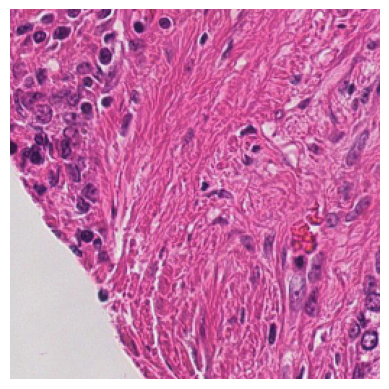

In [17]:
# Show one image
idx = 1 if imgs.shape[0] > 1 else 0
plt.imshow(imgs[idx].cpu().permute(1, 2, 0))
plt.axis("off")

In [18]:
print("Train samples:", len(dataset_train))


Train samples: 15905


In [19]:
print("Val samples:", len(dataset_val))


Val samples: 3493


In [20]:
# Show a couple of rows from the filtered CSV inside the dataset
dataset_train.data.head(3)
# Example paths and labels
for i in range(3):
    r = dataset_train.data.iloc[i]
    print(r["path"], "-> hard_label:", r["hard_label"])


/home/user01/MS-RGCN-Plus/data/VPC/multiscale_patches_Train/slide002_core002/512/40/0_0.png -> hard_label: 4
/home/user01/MS-RGCN-Plus/data/VPC/multiscale_patches_Train/slide002_core002/512/40/512_0.png -> hard_label: 4
/home/user01/MS-RGCN-Plus/data/VPC/multiscale_patches_Train/slide002_core002/512/40/1024_0.png -> hard_label: 4


# Model

In [21]:
class NN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Use the newer torchvision weights API (instead of pretrained=True)
        from torchvision.models import resnet18, ResNet18_Weights
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Final classification layer -> logits for num_classes
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

        print(self.model)

    def forward(self, dictionary):
        # returns logits [B, num_classes]
        return {'label': self.model(dictionary['img'])}

    def prediction(self, dictionary):
        # argmax over logits works for both hard/soft-label training
        return {'label': torch.argmax(self.forward(dictionary)['label'], dim=1)}

model = NN(num_classes=num_classes).cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
checkpoint_file = "../models/model_VPC/40/fold1/256_aug_model_039_0.7346.pt"

def load_model(checkpoint_file, embedding_layer):
    """
    Loads weights into the already-instantiated `model` variable, registers a hook
    on the penultimate layer (avgpool for ResNet-18), and sets eval mode.
    """
    ckpt = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    model.to(device)
    
    return model


# Training

## Training loop

[Epoch 0 | Iter 0/497] loss=1.7778 | last_val_acc=n/a |
[Epoch 0 | Iter 100/497] loss=1.1428 | last_val_acc=n/a |
[Epoch 0 | Iter 200/497] loss=1.0548 | last_val_acc=n/a |
[Epoch 0 | Iter 300/497] loss=1.0759 | last_val_acc=n/a |
[Epoch 0 | Iter 400/497] loss=1.0766 | last_val_acc=n/a |
[Epoch 0 | Iter 497/497] loss=2.6118 | last_val_acc=n/a |


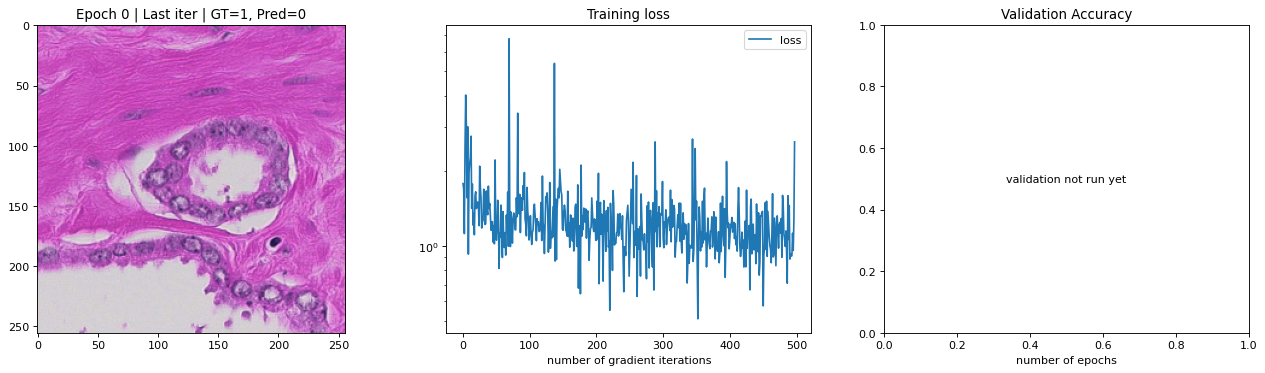

Epoch 0 done | last_loss=2.6118 | val_acc=0.5348 | saved=../models/model_VPC/40/fold1/256_aug_model_000_0.5348.pt
[Epoch 1 | Iter 0/497] loss=1.1430 | last_val_acc=0.5348 |
[Epoch 1 | Iter 100/497] loss=1.1495 | last_val_acc=0.5348 |
[Epoch 1 | Iter 200/497] loss=1.3154 | last_val_acc=0.5348 |
[Epoch 1 | Iter 300/497] loss=1.9556 | last_val_acc=0.5348 |
[Epoch 1 | Iter 400/497] loss=0.7697 | last_val_acc=0.5348 |
[Epoch 1 | Iter 497/497] loss=0.3209 | last_val_acc=0.5348 |


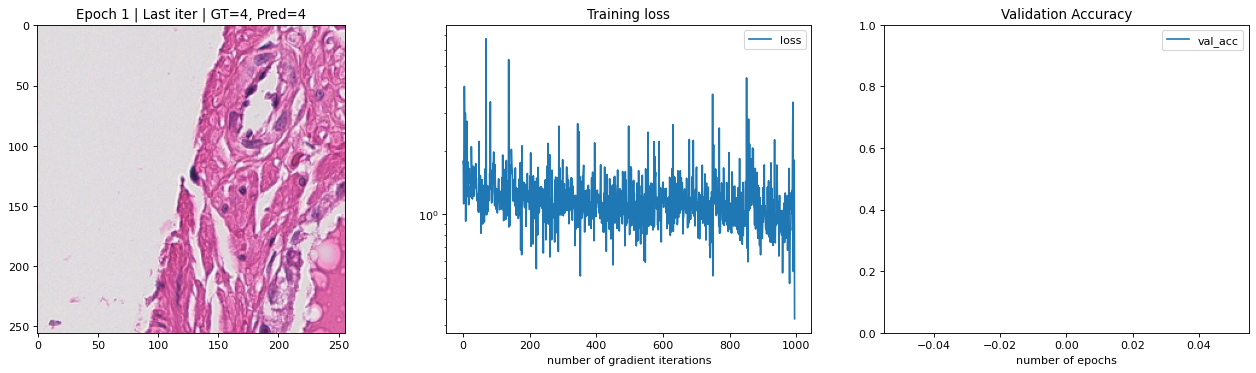

Epoch 1 done | last_loss=0.3209 | val_acc=0.1472 | saved=../models/model_VPC/40/fold1/256_aug_model_001_0.1472.pt
[Epoch 2 | Iter 0/497] loss=0.8775 | last_val_acc=0.1472 |
[Epoch 2 | Iter 100/497] loss=0.8642 | last_val_acc=0.1472 |
[Epoch 2 | Iter 200/497] loss=0.7421 | last_val_acc=0.1472 |
[Epoch 2 | Iter 300/497] loss=1.0777 | last_val_acc=0.1472 |
[Epoch 2 | Iter 400/497] loss=0.8803 | last_val_acc=0.1472 |
[Epoch 2 | Iter 497/497] loss=0.7119 | last_val_acc=0.1472 |


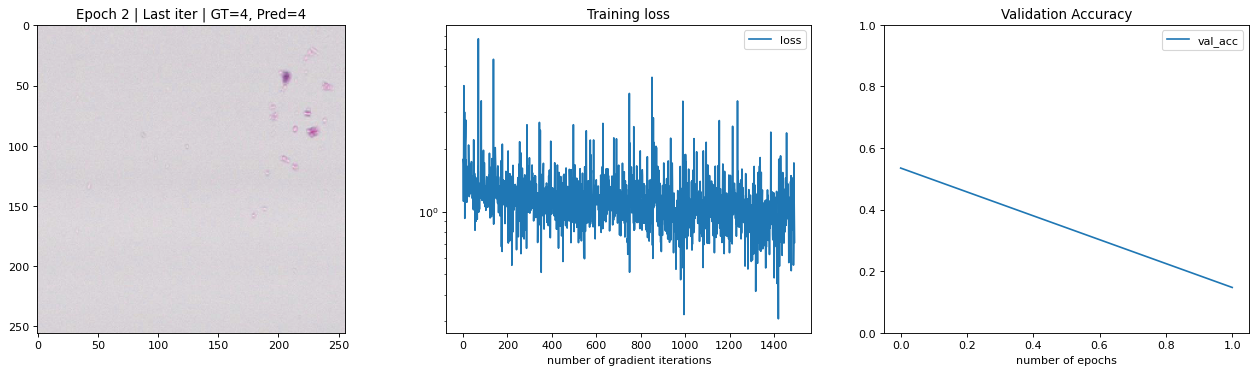

Epoch 2 done | last_loss=0.7119 | val_acc=0.5832 | saved=../models/model_VPC/40/fold1/256_aug_model_002_0.5832.pt
[Epoch 3 | Iter 0/497] loss=0.8441 | last_val_acc=0.5832 |
[Epoch 3 | Iter 100/497] loss=1.0163 | last_val_acc=0.5832 |
[Epoch 3 | Iter 200/497] loss=1.1402 | last_val_acc=0.5832 |
[Epoch 3 | Iter 300/497] loss=1.1473 | last_val_acc=0.5832 |
[Epoch 3 | Iter 400/497] loss=1.1916 | last_val_acc=0.5832 |
[Epoch 3 | Iter 497/497] loss=1.6595 | last_val_acc=0.5832 |


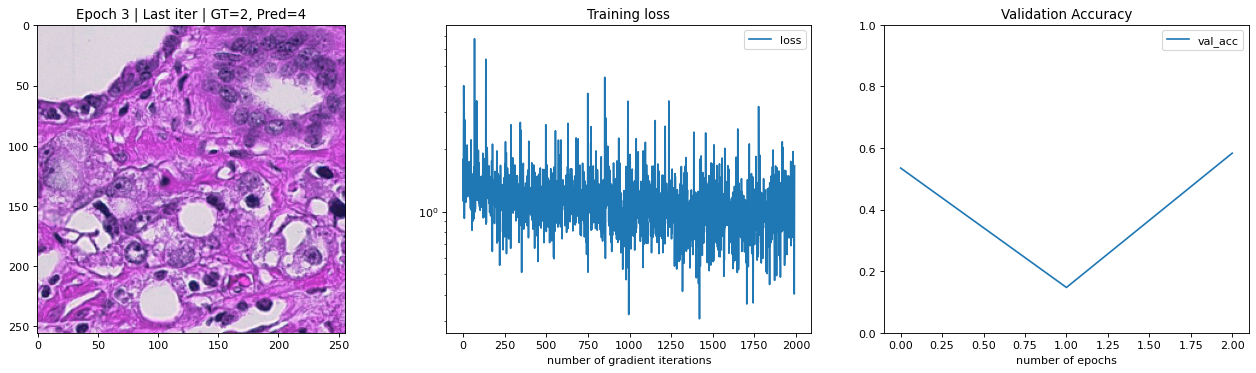

Epoch 3 done | last_loss=1.6595 | val_acc=0.5230 | saved=../models/model_VPC/40/fold1/256_aug_model_003_0.5230.pt
[Epoch 4 | Iter 0/497] loss=0.9632 | last_val_acc=0.5230 |
[Epoch 4 | Iter 100/497] loss=0.7255 | last_val_acc=0.5230 |
[Epoch 4 | Iter 200/497] loss=1.1621 | last_val_acc=0.5230 |
[Epoch 4 | Iter 300/497] loss=1.0144 | last_val_acc=0.5230 |
[Epoch 4 | Iter 400/497] loss=1.0638 | last_val_acc=0.5230 |
[Epoch 4 | Iter 497/497] loss=0.3760 | last_val_acc=0.5230 |


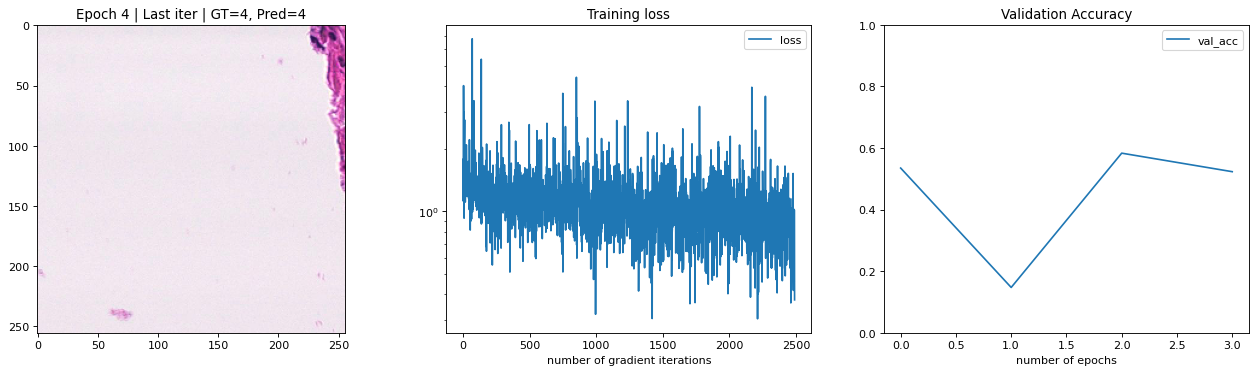

Epoch 4 done | last_loss=0.3760 | val_acc=0.5643 | saved=../models/model_VPC/40/fold1/256_aug_model_004_0.5643.pt
[Epoch 5 | Iter 0/497] loss=0.7050 | last_val_acc=0.5643 |
[Epoch 5 | Iter 100/497] loss=1.1143 | last_val_acc=0.5643 |
[Epoch 5 | Iter 200/497] loss=0.3669 | last_val_acc=0.5643 |
[Epoch 5 | Iter 300/497] loss=1.0508 | last_val_acc=0.5643 |
[Epoch 5 | Iter 400/497] loss=0.3717 | last_val_acc=0.5643 |
[Epoch 5 | Iter 497/497] loss=2.1993 | last_val_acc=0.5643 |


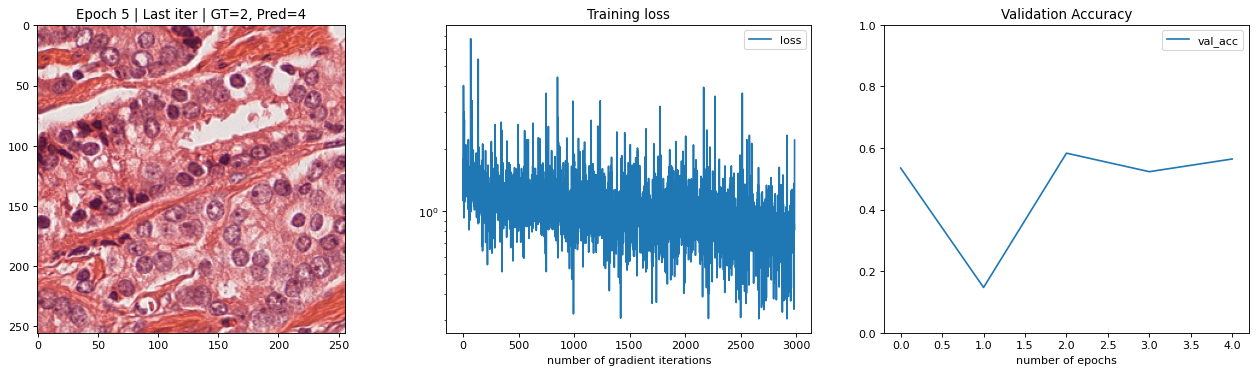

Epoch 5 done | last_loss=2.1993 | val_acc=0.6625 | saved=../models/model_VPC/40/fold1/256_aug_model_005_0.6625.pt
[Epoch 6 | Iter 0/497] loss=0.5663 | last_val_acc=0.6625 |
[Epoch 6 | Iter 100/497] loss=0.4422 | last_val_acc=0.6625 |
[Epoch 6 | Iter 200/497] loss=0.5975 | last_val_acc=0.6625 |
[Epoch 6 | Iter 300/497] loss=0.6904 | last_val_acc=0.6625 |
[Epoch 6 | Iter 400/497] loss=0.4018 | last_val_acc=0.6625 |
[Epoch 6 | Iter 497/497] loss=0.4536 | last_val_acc=0.6625 |


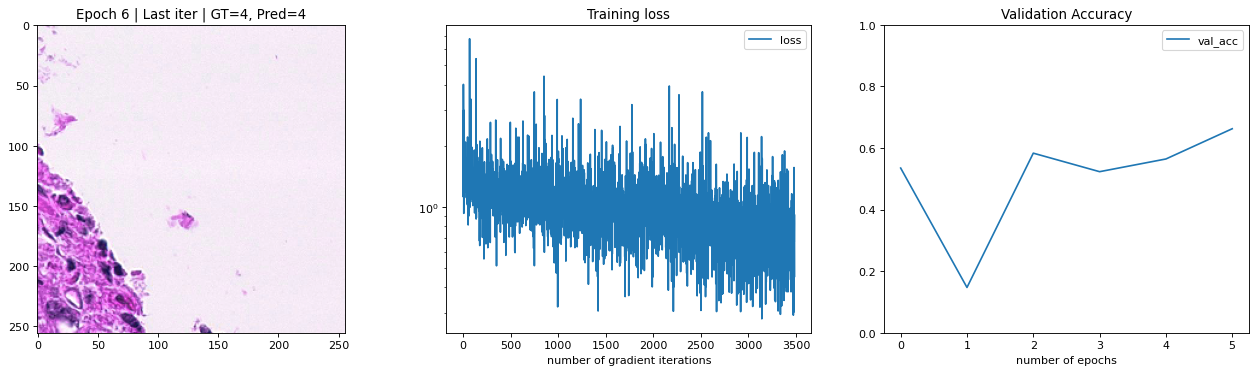

Epoch 6 done | last_loss=0.4536 | val_acc=0.6593 | saved=../models/model_VPC/40/fold1/256_aug_model_006_0.6593.pt
[Epoch 7 | Iter 0/497] loss=0.2721 | last_val_acc=0.6593 |
[Epoch 7 | Iter 100/497] loss=0.7682 | last_val_acc=0.6593 |
[Epoch 7 | Iter 200/497] loss=0.5135 | last_val_acc=0.6593 |
[Epoch 7 | Iter 300/497] loss=0.7294 | last_val_acc=0.6593 |
[Epoch 7 | Iter 400/497] loss=0.3811 | last_val_acc=0.6593 |
[Epoch 7 | Iter 497/497] loss=2.1065 | last_val_acc=0.6593 |


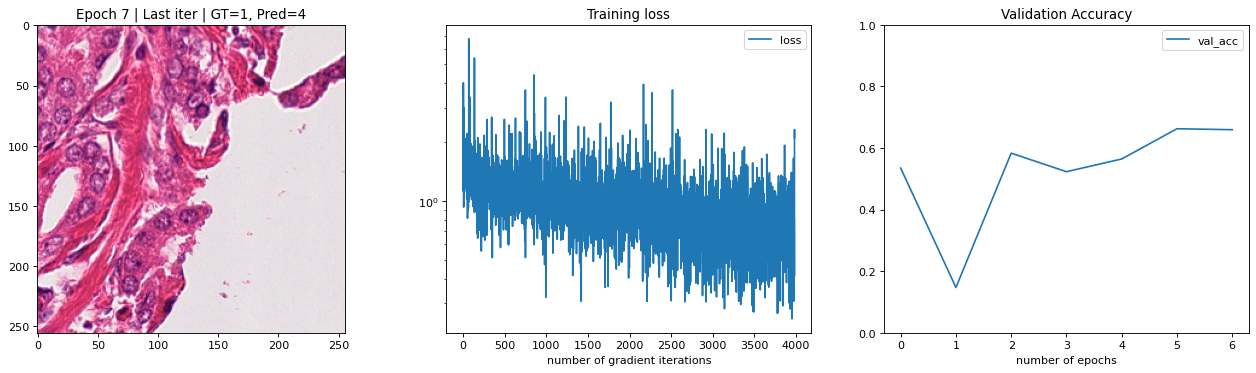

Epoch 7 done | last_loss=2.1065 | val_acc=0.6522 | saved=../models/model_VPC/40/fold1/256_aug_model_007_0.6522.pt
[Epoch 8 | Iter 0/497] loss=0.6484 | last_val_acc=0.6522 |
[Epoch 8 | Iter 100/497] loss=0.8946 | last_val_acc=0.6522 |
[Epoch 8 | Iter 200/497] loss=0.9883 | last_val_acc=0.6522 |
[Epoch 8 | Iter 300/497] loss=1.0101 | last_val_acc=0.6522 |
[Epoch 8 | Iter 400/497] loss=0.5935 | last_val_acc=0.6522 |
[Epoch 8 | Iter 497/497] loss=2.0069 | last_val_acc=0.6522 |


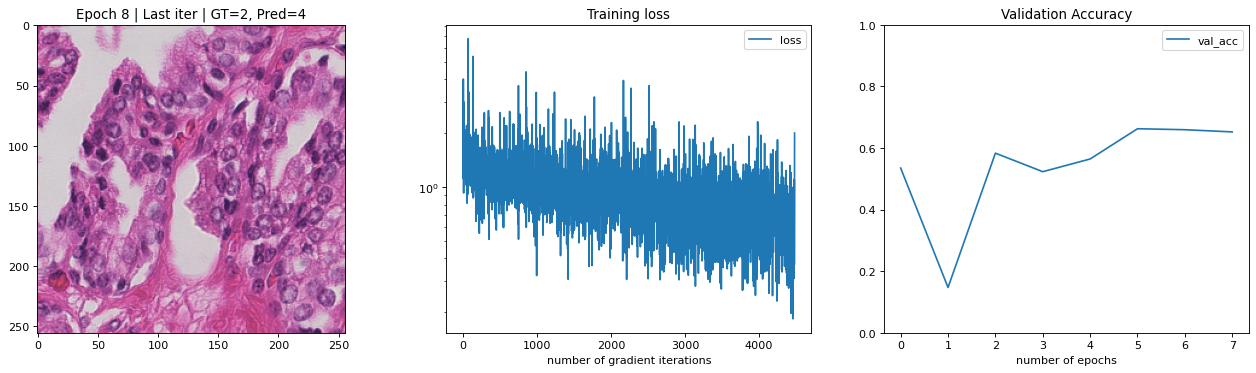

Epoch 8 done | last_loss=2.0069 | val_acc=0.7071 | saved=../models/model_VPC/40/fold1/256_aug_model_008_0.7071.pt
[Epoch 9 | Iter 0/497] loss=0.6770 | last_val_acc=0.7071 |
[Epoch 9 | Iter 100/497] loss=0.5298 | last_val_acc=0.7071 |
[Epoch 9 | Iter 200/497] loss=0.4510 | last_val_acc=0.7071 |
[Epoch 9 | Iter 300/497] loss=0.2594 | last_val_acc=0.7071 |
[Epoch 9 | Iter 400/497] loss=0.7505 | last_val_acc=0.7071 |
[Epoch 9 | Iter 497/497] loss=2.2070 | last_val_acc=0.7071 |


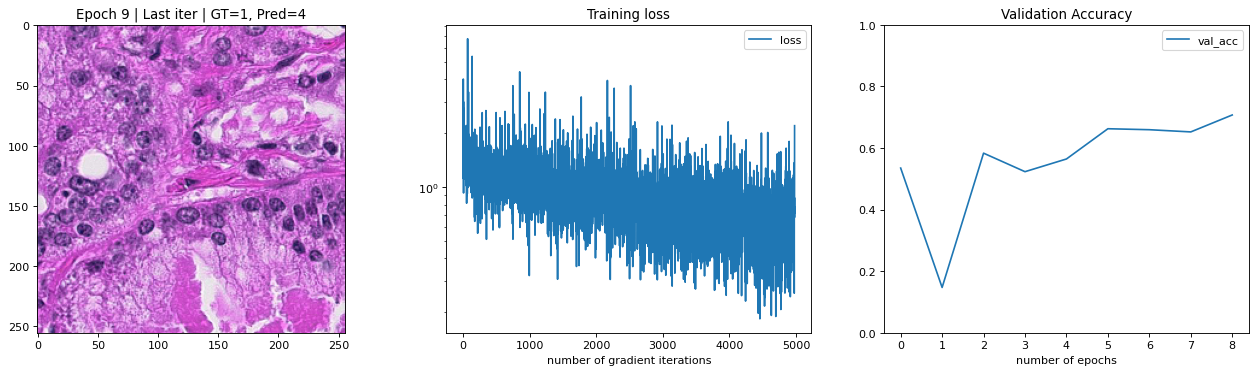

Epoch 9 done | last_loss=2.2070 | val_acc=0.6464 | saved=../models/model_VPC/40/fold1/256_aug_model_009_0.6464.pt
[Epoch 10 | Iter 0/497] loss=0.5428 | last_val_acc=0.6464 |
[Epoch 10 | Iter 100/497] loss=0.3941 | last_val_acc=0.6464 |
[Epoch 10 | Iter 200/497] loss=0.4649 | last_val_acc=0.6464 |
[Epoch 10 | Iter 300/497] loss=0.3651 | last_val_acc=0.6464 |
[Epoch 10 | Iter 400/497] loss=0.5872 | last_val_acc=0.6464 |
[Epoch 10 | Iter 497/497] loss=0.3265 | last_val_acc=0.6464 |


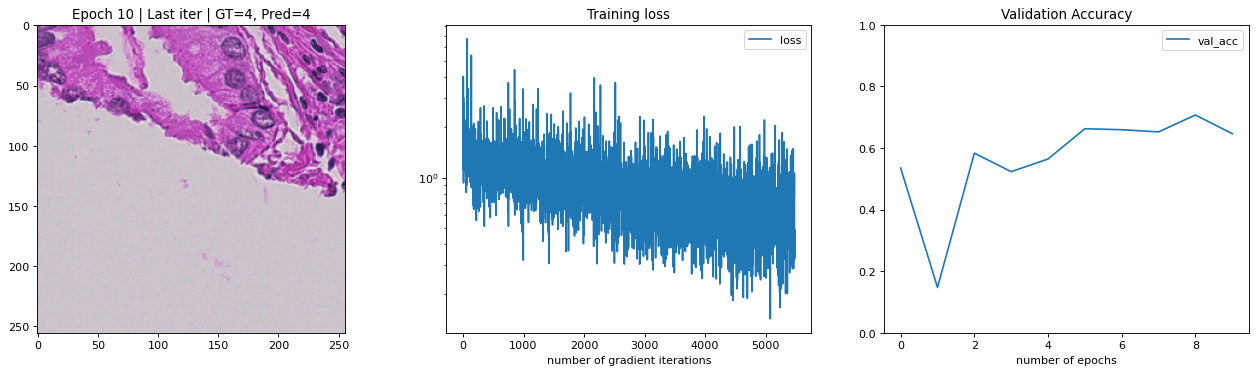

Epoch 10 done | last_loss=0.3265 | val_acc=0.6859 | saved=../models/model_VPC/40/fold1/256_aug_model_010_0.6859.pt
[Epoch 11 | Iter 0/497] loss=0.3725 | last_val_acc=0.6859 |
[Epoch 11 | Iter 100/497] loss=0.6701 | last_val_acc=0.6859 |
[Epoch 11 | Iter 200/497] loss=1.3102 | last_val_acc=0.6859 |
[Epoch 11 | Iter 300/497] loss=0.3114 | last_val_acc=0.6859 |
[Epoch 11 | Iter 400/497] loss=0.5142 | last_val_acc=0.6859 |
[Epoch 11 | Iter 497/497] loss=1.8402 | last_val_acc=0.6859 |


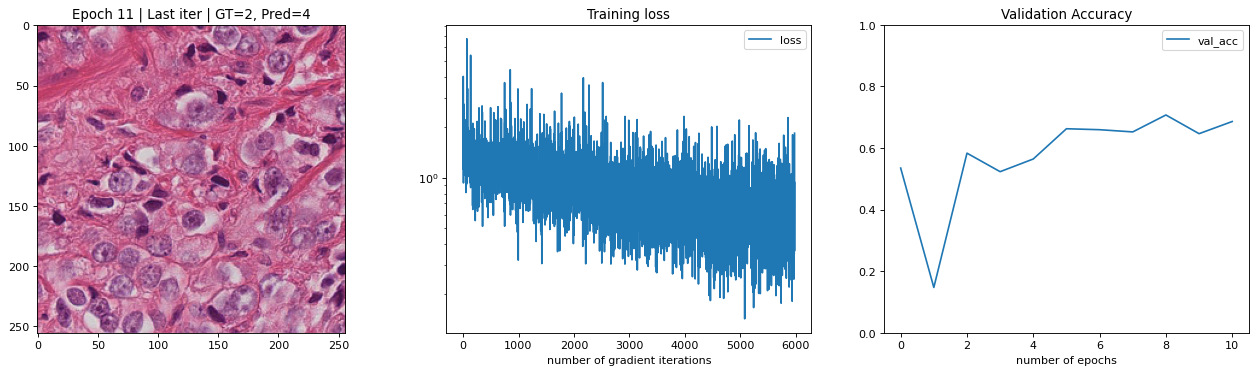

Epoch 11 done | last_loss=1.8402 | val_acc=0.7126 | saved=../models/model_VPC/40/fold1/256_aug_model_011_0.7126.pt
[Epoch 12 | Iter 0/497] loss=0.6764 | last_val_acc=0.7126 |
[Epoch 12 | Iter 100/497] loss=0.6836 | last_val_acc=0.7126 |
[Epoch 12 | Iter 200/497] loss=0.9076 | last_val_acc=0.7126 |
[Epoch 12 | Iter 300/497] loss=0.7079 | last_val_acc=0.7126 |
[Epoch 12 | Iter 400/497] loss=0.7900 | last_val_acc=0.7126 |
[Epoch 12 | Iter 497/497] loss=0.4120 | last_val_acc=0.7126 |


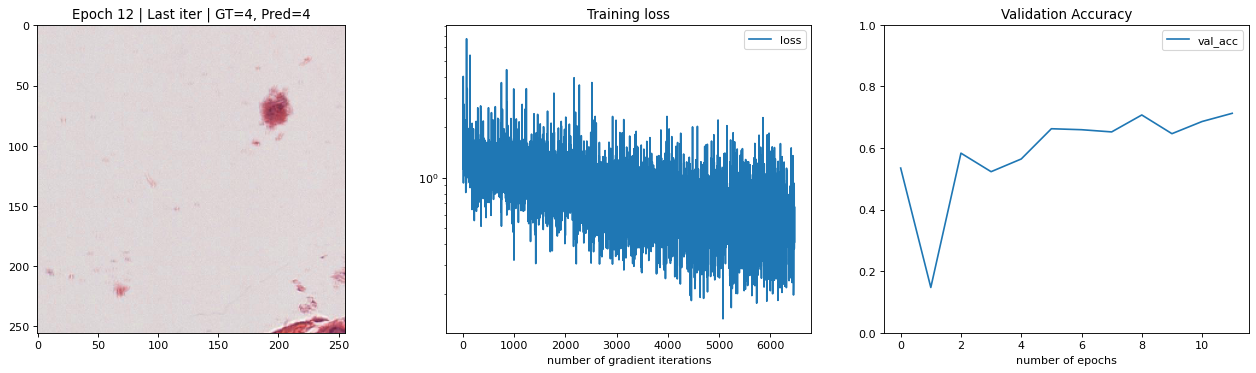

Epoch 12 done | last_loss=0.4120 | val_acc=0.6902 | saved=../models/model_VPC/40/fold1/256_aug_model_012_0.6902.pt
[Epoch 13 | Iter 0/497] loss=0.7914 | last_val_acc=0.6902 |
[Epoch 13 | Iter 100/497] loss=0.4369 | last_val_acc=0.6902 |
[Epoch 13 | Iter 200/497] loss=0.3964 | last_val_acc=0.6902 |


In [ ]:
# --- one-time: make sure the checkpoint dir exists ---
import os
os.makedirs(os.path.dirname(model_results_path), exist_ok=True)

# prepare plotting (single figure reused each epoch)
fig = plt.figure(figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
axes = fig.subplots(1, 3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 25], gamma=0.1)

device = "cuda"

# ---------- class weights from training CSV ----------
import numpy as np
import torch.nn.functional as F

if "hard_label" in dataset_train.data.columns:
    counts = np.bincount(dataset_train.data["hard_label"].astype(int).values, minlength=num_classes)
    class_weights = 1.0 / (counts + 1)
    class_weights = class_weights / class_weights.sum()
    weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
else:
    weights = torch.ones(num_classes, device=device) / num_classes  # fallback

# ---------- losses ----------
criterion_hard = nn.CrossEntropyLoss(weight=weights)

def soft_ce_loss(logits, target_probs):
    log_probs = F.log_softmax(logits, dim=1)
    loss_per_sample = -(target_probs * log_probs).sum(dim=1)
    return loss_per_sample.mean()

num_epochs = 41

losses = []
val_accs = []

log_every = 100  # print every N iters

for epoch in range(num_epochs): 
    # --------- TRAIN ---------
    model.train()
    for i, batch_cpu in enumerate(train_loader):
        batch_gpu = dict_to_device(batch_cpu, device)
        pred = model(batch_gpu)  # {'label': logits [B, C]}

        # choose loss based on label type (hard vs soft)
        if isinstance(batch_gpu['label'], torch.Tensor) and batch_gpu['label'].ndim == 2:
            loss = soft_ce_loss(pred['label'], batch_gpu['label'])
        else:
            loss = criterion_hard(pred['label'], batch_gpu['label'].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # --------- PRINT LOGS (no plotting here) ---------
        if (i % log_every == 0) or (i == len(train_loader) - 1):
            # define last_val_str safely even before first validation
            last_val_str = f"{val_accs[-1]:.4f}" if len(val_accs) > 0 else "n/a"

            # optional: show current GT/PRED ids in the log line
            # if isinstance(batch_cpu['label'], torch.Tensor) and batch_cpu['label'].ndim == 2:
            #     gt_id = int(torch.argmax(batch_cpu['label'][0]).item())
            # else:
            #     gt_id = int(batch_cpu['label'][0])
            # pred_id = int(torch.argmax(pred['label'][0]).item())

            # print(f"[Epoch {epoch} | Iter {i}/{len(train_loader)-1}] "
            #       f"loss={losses[-1]:.4f} | last_val_acc={last_val_str} | GT={gt_id} Pred={pred_id}")
            
            
            print(f"[Epoch {epoch} | Iter {i}/{len(train_loader)-1}] "
                  f"loss={losses[-1]:.4f} | last_val_acc={last_val_str} |")

        # ---- plot ONLY at the end of the epoch (when i hits last iter) ----
        if i == len(train_loader) - 1:
            # clear axes so each epoch snapshot is clean
            axes[0].cla(); axes[1].cla(); axes[2].cla()

            # left: show an input image + title
            from matplotlib import pyplot as plt
            plotImage(batch_cpu['img'][0], ax=axes[0])
            if isinstance(batch_cpu['label'], torch.Tensor) and batch_cpu['label'].ndim == 2:
                gt_label = int(torch.argmax(batch_cpu['label'][0]).item())
            else:
                gt_label = int(batch_cpu['label'][0])
            pred_top1 = int(torch.argmax(pred['label'][0]).item())
            axes[0].set_title(f'Epoch {epoch} | Last iter | GT={gt_label}, Pred={pred_top1}')

            # middle: training loss curve
            axes[1].plot(losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # right: validation accuracy curve (may be empty on epoch 0 pre-val)
            if len(val_accs) > 0:
                axes[2].plot(val_accs, label='val_acc')
                axes[2].set_ylim(0, 1)
                axes[2].legend()
            else:
                axes[2].text(0.5, 0.5, "validation not run yet", ha='center', va='center')
                axes[2].set_ylim(0, 1)
            axes[2].set_title('Validation Accuracy')
            axes[2].set_xlabel('number of epochs')

            display.display(plt.gcf())  # append a snapshot for this epoch

    # --------- VALIDATION ---------
    model.eval()
    n_val = len(dataset_val)
    pred_val = np.zeros(n_val, dtype=np.int64)
    label = np.zeros(n_val, dtype=np.int64)

    offset = 0
    with torch.no_grad():
        for j, batch_cpu in enumerate(val_loader):
            batch_gpu = dict_to_device(batch_cpu, device)
            preds = model.prediction(batch_gpu)['label'].cpu().numpy()

            labels_cpu = batch_cpu['label']
            if isinstance(labels_cpu, torch.Tensor) and labels_cpu.ndim == 2:
                labels_np = torch.argmax(labels_cpu, dim=1).cpu().numpy()
            else:
                labels_np = labels_cpu.cpu().numpy() if isinstance(labels_cpu, torch.Tensor) else labels_cpu

            bsz = labels_np.shape[0]
            pred_val[offset:offset+bsz] = preds
            label[offset:offset+bsz] = labels_np
            offset += bsz

    val_acc = float((label == pred_val).mean())
    val_accs.append(val_acc)

    # --------- SAVE CHECKPOINT ---------
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses[-1],
        'val_acc': val_acc
    }
    ckpt_path = model_results_path + f'_{epoch:03d}_{val_acc:.4f}.pt'
    torch.save(state, ckpt_path)

    print(f"Epoch {epoch} done | last_loss={losses[-1]:.4f} | val_acc={val_acc:.4f} | saved={ckpt_path}")

    # --------- Scheduler ---------
    scheduler.step()

plt.close('all')
